# Twitter Classifier

## Description
For this project, I will be building a Twitter classifier.  I am pulling the most recent ~3200 tweets from four twitter handles: realDonaldTrump, junstinbieber, hillaryclinton, and katyperry.  I will then be using a variety of supervised and unsupervised models to classify the tweets in different ways.

Let the fun begin!

In [1]:
import tweepy

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans


consumer_key = '9SRz5HMehrEVQf2m7AoN4shrq'
consumer_secret = 'zZa9j55quKFTmTwm4PKx4B6RUn3OyCsEtVJmvqbLAX9d8K3Adu'
access_token = '2801486303-55EJTjYXUPvw5uzXmRQV8wTHDmiLh70BJoASUj9'
access_token_secret = 'aRGfnR8N4if56loNt0yhwChXBe61go8qTpEanmXV2RBRp'

In [2]:
# Thank you, yanofsky! Adapted from: https://gist.github.com/yanofsky/5436496

def get_all_tweets(screen_names):

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    
    #initialize a list to hold all the tweepy Tweets
    df = pd.DataFrame()
    
    for screen_name in screen_names:
        
        alltweets = []

        #make initial request for most recent tweets (200 is the maximum allowed count)
        new_tweets = api.user_timeline(screen_name = screen_name ,count=200)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #save the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        #keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:
            print("getting tweets before %s" % (oldest))

            #all subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

            #save most recent tweets
            alltweets.extend(new_tweets)

            #update the id of the oldest tweet less one
            oldest = alltweets[-1].id - 1

            print("...%s tweets downloaded so far" % (len(alltweets)))

        #transform the tweepy tweets into a 2D array that will populate the csv	
        outtweets = [[tweet.user.screen_name, tweet.text] for tweet in alltweets]

        df = df.append(pd.DataFrame(data=outtweets)).reset_index(drop=True)
        
    return df
    
    print('done!')

These twitter accounts were chosen with some trial and error.  Since we are only allowed to pull tweets from the last week or so, I wanted to make sure to get prolific tweeters in the dataset.  That way we have a well balanced dataset.

In [3]:
# Getting the most recent 3200 tweets from Donald Trump, Justin Bieber, Hillary Clinton, 
# and Katy Perry.
tweets = get_all_tweets(['realDonaldTrump','justinbieber','hillaryclinton','katyperry'])

getting tweets before 989813047773614079
...400 tweets downloaded so far
getting tweets before 980958298445885445
...600 tweets downloaded so far
getting tweets before 967597887545896960
...800 tweets downloaded so far
getting tweets before 954681839419101184
...1000 tweets downloaded so far
getting tweets before 945030174290186240
...1197 tweets downloaded so far
getting tweets before 935339687006429184
...1397 tweets downloaded so far
getting tweets before 925716689064427519
...1597 tweets downloaded so far
getting tweets before 918275261011038209
...1796 tweets downloaded so far
getting tweets before 911546774267006975
...1996 tweets downloaded so far
getting tweets before 902507855584092159
...2196 tweets downloaded so far
getting tweets before 894367017054208000
...2396 tweets downloaded so far
getting tweets before 885109663217352703
...2596 tweets downloaded so far
getting tweets before 875843513761583103
...2795 tweets downloaded so far
getting tweets before 861592420043157503


In [4]:
tweets[0].value_counts()

HillaryClinton     3236
realDonaldTrump    3232
katyperry          3218
justinbieber       3171
Name: 0, dtype: int64

Great! We have about 3200 tweets from each twitter account.  Having a balanced dataset will make the predictive models more accurate. 

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12857 entries, 0 to 12856
Data columns (total 2 columns):
0    12857 non-null object
1    12857 non-null object
dtypes: object(2)
memory usage: 201.0+ KB


In [6]:
tweets.columns = ['screenname','tweet']

In [7]:
tweets['tweet'] = tweets['tweet'].astype(str)

Let's clean the tweets to remove links and drop tweets that are retweets.

In [8]:
def text_cleaner(tweet):
    tweet = re.sub(r'http.*','',tweet)
    tweet = re.sub(r'bit/ly.*', "", tweet)
    tweet = re.sub(r'b\'', "", tweet)
    tweet = re.sub(r'b"', "", tweet)
    return tweet

In [9]:
for r in range(len(tweets['tweet'])):
    tweets['tweet'][r] = text_cleaner(tweets['tweet'][r])

#Dropping retweets    
tweets = tweets[tweets['tweet'].str.contains("RT") == False].reset_index(drop=True)
    

Now to parse the tweens using spacy.

Helpful link about disabling piplines to make nlp run faster: https://spacy.io/usage/processing-pipelines#disabling

In [10]:
# Concatenizing all tweets into one text and parsing.
nlp = spacy.load('en', disable=['parser'])

text = tweets['tweet'].str.cat()
text = nlp(text)

In [11]:
# Parse tweets
nlp = spacy.load('en')

parsed = []

for r in tweets['tweet']:
    p = nlp(r)
    parsed.append(p)
    
    

In [12]:
tweets['parsed'] = parsed

In [13]:
tweets.head()

,screenname,tweet,parsed
0,realDonaldTrump,Crippling loopholes in our laws have enabled M...,"(Crippling, loopholes, in, our, laws, have, en..."
1,realDonaldTrump,"Today on Long Island, we were all moved to be ...","(Today, on, Long, Island, ,, we, were, all, mo..."
2,realDonaldTrump,Thank you @SBAList! #SBAGala,"(Thank, you, @SBAList, !, #, SBAGala)"
3,realDonaldTrump,WITCH HUNT!,"(WITCH, HUNT, !)"
4,realDonaldTrump,There will be big news coming soon for our gre...,"(There, will, be, big, news, coming, soon, for..."


Success!

# Supervised Learning Models

## Bag of Words
Let's use bag of words! For each tweet, we will count how many times each word appears and use those counts as features for our supervised learning models.  To keep our feature space manageable, we will be using lemmas (root words), and we will only use the top 1000 most common words for each text.

In [14]:
# Utility function to create a list of the 1000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(tweets, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = tweets['parsed']
    df['text_source'] = tweets['screenname']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df


In [15]:
# Finding the top 1000 common words in all the tweets.

common_words = bag_of_words(text)

In [16]:
# Create our data frame with features. 
word_counts = bow_features(tweets, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000


,-PRON-,be,trump,not,great,amp,,the,thank,'s,...,primary,loss,representative,nothing,h,august,budget,june,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Crippling, loopholes, in, our, laws, have, en...",realDonaldTrump
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Today, on, Long, Island, ,, we, were, all, mo...",realDonaldTrump
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"(Thank, you, @SBAList, !, #, SBAGala)",realDonaldTrump
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(WITCH, HUNT, !)",realDonaldTrump
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, will, be, big, news, coming, soon, for...",realDonaldTrump


Each row represents a tweet.  Each column contains one of the top 1000 common words.  If the tweet contains that word the corresponding space is marked '1'. 

In [17]:
word_counts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10279 entries, 0 to 10278
Columns: 1002 entries, -PRON- to text_source
dtypes: object(1002)
memory usage: 78.6+ MB


In [18]:
#word_counts.to_csv('tweet_word_counts.csv')

### Models for BoW
I will be using the dataframe created from Bag of Words to classify our tweets with Random Forest, Multinomial Logistic Regression, Gradient Boost, and Support Vector Machine.  

In [19]:
# Train-test split
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0,
                                                    stratify=Y
                                                   )

In [20]:
y_train.value_counts()

realDonaldTrump    1720
katyperry          1714
HillaryClinton     1532
justinbieber       1201
Name: text_source, dtype: int64

In [21]:
y_test.value_counts()

realDonaldTrump    1147
katyperry          1142
HillaryClinton     1022
justinbieber        801
Name: text_source, dtype: int64

#### Random forest

In [22]:
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.948435219717853

Test set score: 0.7412451361867705


Looks like there is an issue with overfitting here.  The training score is much higher than the test set.  

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(rfc, X, Y, cv=5)

array([0.60544218, 0.72581429, 0.71581509, 0.71970803, 0.69376826])

There is some variations in the cross validation scores, which again points to overfitting.  Random forest is probably not the best model for this dataset.

In [151]:
y_pred = rfc.fit(X_train, y_train).predict(X_train)

ValueError: could not convert string to float: 'Thank you to @exxonmobil for your $20 billion investment that is creating more than 45,000 manufacturing &amp; construction jobs in the USA!'

In [25]:
from collections import Counter
Counter(y_pred)

Counter({'HillaryClinton': 1524,
         'justinbieber': 1428,
         'katyperry': 1520,
         'realDonaldTrump': 1695})

In [26]:
# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
conf_matrix

array([[1502,   24,    4,    2],
       [   4, 1176,   18,    3],
       [   6,  210, 1494,    4],
       [  12,   18,    4, 1686]])

#### Multinomial Logistic Regression

Multinomail Logistic regression allows us to classify the tweets into multiple categories.  It is a multi-equation model

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(6167, 1000) (6167,)
Training set score: 0.8963839792443652

Test set score: 0.8132295719844358


Hey not bad!  The training set is pretty close to the test set.  And it is a pretty high score!  Looks like logistic regression is pretty good at predicting which tweets belong to which tweeter.  

In [28]:
cross_val_score(lr, X, Y, cv=5)

array([0.71282799, 0.81623724, 0.80145985, 0.82238443, 0.78578384])

#### Gradient Boost

In [29]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))


Training set score: 0.7814172206907735

Test set score: 0.7456225680933852


In [30]:
cross_val_score(clf, X, Y, cv=5)

array([0.61758989, 0.73164803, 0.75523114, 0.77761557, 0.74148004])

#### SVM

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# Set the parameters by cross-validation
def gridsearch(X_train, y_train, X_test, y_test):
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                     'C': [1, 10, 100, 1000, 10000]}]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                           scoring='%s_macro' % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [32]:
# To speed up production, we are going to take the X and Y test dataset, split it for testing and training
#  and use grid search on that.  A smaller dataset will hopefully make this run faster.
X2_train, X2_test, y2_train, y2_test = train_test_split(X_test, y_test, test_size=0.4,
                                                    random_state=0, stratify=y_test)

In [33]:
y2_train.value_counts(1)

realDonaldTrump    0.278881
katyperry          0.277665
HillaryClinton     0.248480
justinbieber       0.194974
Name: text_source, dtype: float64

In [34]:
#Show warning once
import warnings
warnings.filterwarnings('once')

gridsearch(X2_train, y2_train, X2_test, y2_test)

# Tuning hyper-parameters for precision



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classificatio

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.320 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-07, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-08, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-09, 'kernel': 'rbf'}
0.732 (+/-0.057) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.320 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-09, '

In [35]:
svc = SVC(C=100, gamma=0.001, kernel='rbf')

svc.fit(X_train, y_train)


print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

Training set score: 0.8639532998216313

Test set score: 0.796692607003891


In [36]:
cross_val_score(svc, X, Y, cv=5)

array([0.6797862 , 0.79484686, 0.79026764, 0.82189781, 0.77702045])

Of the different models built on BoW, it looks like logistic regression is least prone to overfitting and has the highest cross validation scores.  

# Unsupervised Learning Models

## Latent Semantic Analysis
What if we don't have information on the handle that the tweet belongs to?  How could the tweets be categorized?  For this unsupervised learning problem, I will be using Latent Semantic Analysis to generate clusters of terms that reflects a topic.  First, I will use tf-idf, which converts the tweets into vectors.  Then I will apply dimension reduction (Singular Value Decomposition SVD) to reduce the feature space and generate the clusters.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [117]:
X3_train, X3_test, y3_train, y3_test  = train_test_split(tweets['tweet'], tweets['screenname'],
                                                test_size=0.25, stratify=tweets['screenname'])

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Donald Trump has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer tweets and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X3_train_tfidf = vectorizer.fit_transform(X3_train)
print("Number of features for training set: %d" % X3_train_tfidf.get_shape()[1])



#Reshapes the vectorizer output into something people can read
X3_train_tfidf_csr = X3_train_tfidf.tocsr()


#number of tweets
n = X3_train_tfidf_csr.shape[0]
print('number of tweets in training set: %d' %n)


#A list of dictionaries, one per tweet
train_tfidf_bytweet = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features for training set: 3447
number of tweets in training set: 7709


In [118]:
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X3_train_tfidf_csr.nonzero()):
    train_tfidf_bytweet[i][terms[j]] = X3_train_tfidf_csr[i, j]

In [119]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X3_train.iloc[4])
print('Tf_idf vector:', train_tfidf_bytweet[4])

Original sentence: If Sophia Grace plays her new trap hit at Coachella... I'll go. cc @yungskeeter @sofifii
Tf_idf vector: {'grace': 0.375351063445984, 'new': 0.21379439819596613, 'trap': 0.375351063445984, 'hit': 0.3096933172037104, 'coachella': 0.3682590094735298, 'll': 0.25734471212717297, 'cc': 0.3474644019121213, 'yungskeeter': 0.375351063445984, 'sofifii': 0.3363691908824324}


In [120]:
#Applying the vectorizer to test set
X3_test_tfidf = vectorizer.fit_transform(X3_test)
print("Number of features for test set: %d" % X3_test_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X3_test_tfidf_csr = X3_test_tfidf.tocsr()

#Number of tweets
m = X3_test_tfidf_csr.shape[0]
print('number of tweets in test set: %d' %m)

#A list of dictionaries, one per tweet
test_tfidf_bytweet = [{} for _ in range(0,m)]

Number of features for test set: 1354
number of tweets in test set: 2570


In [121]:
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X3_test_tfidf_csr.nonzero()):
    test_tfidf_bytweet[i][terms[j]] = X3_test_tfidf_csr[i, j]

In [122]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X3_test.iloc[0])
print('Tf_idf vector:', test_tfidf_bytweet[0])

Original sentence: Not mad. Thanks 
Tf_idf vector: {'fit': 1.0}


## K-means clustering
K-Means groups data into clusters of similar data points with similar variances.  It uses an algorithm that chooses means (centroids) that minimize the cost function.  In this case, the cost function is inertia, calculated as the sum of squared differences between the centroid of the cluster and the data points in the cluster.  The goal is to define cluster means so that the distance between the cluster mean and all the data points in that cluster is as small as possible.

Let's see how k-means clusters our tweets!


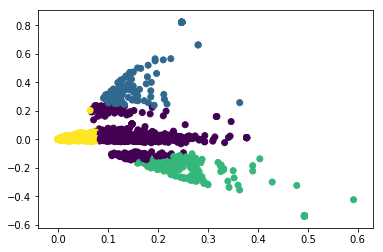

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                      986           196        163              737
1                       10           108         15                3
2                       16            81         13               66
3                      903          1117       1951             1344


In [123]:
from sklearn.decomposition import TruncatedSVD

# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_train_norm = normalize(X3_train_tfidf)
X_test_norm = normalize(X3_test_tfidf)

# Reduce it to two components.
X_train_svd = svd.fit_transform(X_train_norm)
X_test_svd = svd.fit_transform(X_test_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_train_svd)

# Plot the solution.
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y3_train))

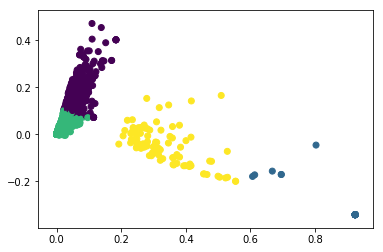

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                      360            57         54              243
1                        0            17          4                5
2                      270           408        645              417
3                        9            18         11               52


In [124]:
# Calculate predicted values.
y_test_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_test_svd)

# Plot the solution.
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=y_test_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_test_pred, y3_test))

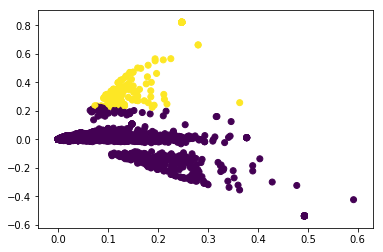

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                     1903          1384       2125             2147
1                       12           118         17                3


In [125]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_svd)

# Plot the solution.
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y3_train))

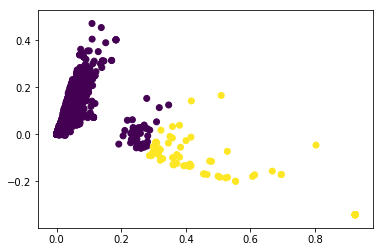

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                      635           468        703              688
1                        4            32         11               29


In [126]:
# Calculate predicted values.
y_test_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_test_svd)

# Plot the solution.
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=y_test_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_test_pred, y3_test))

There are several assumptions of k-means that make it not the best fit for our Twitter data.  First of all, it assumes that the clusters are the same size.  While we have about equal number of tweets from each twitter account, it is clear from the graphs that the clusters are not the same size.  Additionally, k-means assume that the clusters are radially symmetrical (isotropic), meaning the clusters are uniform in all directions and have edges that curve outward.  Lastly, k-means assumes that the clusters have similar variances.  The graphs show that the clusters are not radially symmetrical or have similar variances.  

## Mean-shift clustering
Mean-shift works by calculating the probability that a datapoint will be present at any point in an n-dimensional space, forming a kernel density surface.  Areas with "hills" have a high concentration of datapoints.  Flat areas or valleys have very few data points.  Then, each data point is iteratively shifted "up" a tiny bit the nearest hill.  Once all the data points have reached their peaks and any further shifts are smaller than a given thresholds, the algorithm ends and the data points are assigned a cluster based on their peak. 

Mean-shift clustering is more flexible than k-means, because it does not assume that the clusters have to be the same size or radially symmetric.  The clusters can have non-flay geometry.

In [129]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_pca, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_svd)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 28


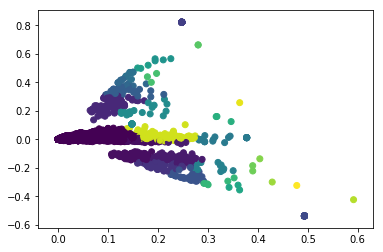

Comparing the assigned categories to the ones in the data:
col_0              0    1   2   3   4   5   6   7   8   9  ...  18  19  20  \
screenname                                                 ...               
HillaryClinton   1701   33   7  13   7   0   1   1   1   1 ...   0   0   0   
justinbieber     1236   14   8  47  22  32  20  23  25  10 ...   5   3   1   
katyperry        2065   28   2  14   4   2   2   5   1   1 ...   0   0   1   
realDonaldTrump  1868  130  40   5  13   0   7   6   0   0 ...   1   0   0   

col_0            21  22  23  24   25  26  27  
screenname                                    
HillaryClinton    0   0   0   0  139   0   0  
justinbieber      1   0   0   1   17   0   0  
katyperry         0   0   0   0    6   0   0  
realDonaldTrump   1   1   1   0   44   1   1  

[4 rows x 28 columns]


In [130]:
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y3_train,labels))

In [131]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_test_svd, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_test_svd)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 15


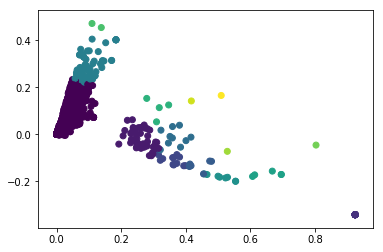

Comparing the assigned categories to the ones in the data:
col_0             0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
screenname                                                                  
HillaryClinton   588   6   0   0   0   0  40   1   0   1   2   0   1   0   0
justinbieber     460   5  13   5   5   0   5   3   3   0   0   1   0   0   0
katyperry        699   6   2   1   1   2   0   1   2   0   0   0   0   0   0
realDonaldTrump  637  29   5   6   1   8  23   3   0   3   0   0   0   1   1


In [135]:
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y3_test,labels))

## Spectral Clustering

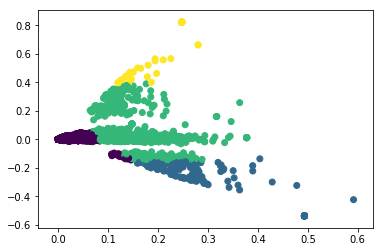

Comparing the assigned categories to the ones in the data:
col_0               0   1     2   3
screenname                         
HillaryClinton    886  12  1016   1
justinbieber     1081  78   291  52
katyperry        1941  12   182   7
realDonaldTrump  1350  46   752   2


In [133]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=4

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_svd)

#Predicted clusters.
predict=sc.fit_predict(X_train_svd)

#Graph results.
plt.scatter(X_train_svd[:, 0], X_train_svd[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y3_train,predict))

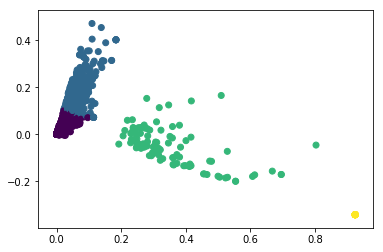

Comparing the assigned categories to the ones in the data:
col_0              0    1   2   3
screenname                       
HillaryClinton   269  361   9   0
justinbieber     408   57  22  13
katyperry        644   55  13   2
realDonaldTrump  416  244  52   5


In [134]:
# We know we're looking for three clusters.
n_clusters=4

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_test_svd)

#Predicted clusters.
predict=sc.fit_predict(X_test_svd)

#Graph results.
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y3_test,predict))

## SVD

So we see that reducing the feature space to 2 components is too limiting, though it does provide nice visuals into how each type of clustering algorithm may group the tweets based on these two vectors.  Let's increase our feature space to 200.  We won't be able to visuallize it, but we can better see how unsupervised learning is grouping these tweets.

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space to 200 components.
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100, '\n')

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(10):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    print('\n')


Percent variance captured by all components: 33.51348978169217 

Component 0:
tweet
Great show. Thank you                                                                                                                   0.708475
#PurposeTourGlendale another great show. Thank u                                                                                        0.708475
THANK YOU to all of the great volunteers helping out with #HurricaneHarvey relief in Texas!                                             0.677287
Thank you Louisville, Kentucky. Together, we will MAKE AMERICA SAFE AND GREAT AGAIN!                                                    0.634421
Thank you to the GREAT NYPD, First Responders and all govt officials for having handled the terrible West Side atta…                    0.616605
My experience yesterday in Poland was a great one. Thank you to everyone, including the haters, for the great reviews of the speech!    0.611713
Thank you for the great rallies all across the

SVD compresses features into independent components that are not correlated with any other components.  We are going to lose some of the information due to this compression.  But we can explain 34% of the variance. 

The first three clusters have to do with thanks.  The fourth cluster capture tweets with the word "great."  Make America Great Again tweets compose a good potion of this cluster.  Fifth cluster is around "love".  Sixth cluster are tweets that contain amperstands (&). Seventh cluster are lols.  Eighth and ninth cluster has the word "purpose", which is the title of Justin Beiber's new album.   The final cluster is about American Idol, which currently stars Katy Perry. 

In summary, some of the clusters do focus more on one twitter handle over the others. The "great" cluster is Donald Trump MAGA oriented.  #Purpose is mostly Justin Beiber.  #AmericanIdol is Katy Perry.  

# Word2vec
Word2vec is the most common unsupervised neural network approach for NLP.  It converts words to vectors using distributed representation, where each word is represented by many neurons, and each neuron represents multiple words.  word2vec is powerful because it assigns a vector of random values to each word W, then shifts the vectors for the words around W in the sentence.  Words that are close to W have vectors that are closer together, while words that are not near W have vectors that are also far away.  Word2vec is great for tweets because tweets can contain the same concepts written in many different ways (e.g. expressing thanks).

We do need are larger corpus when using word2vec.  So first, let's generate more tweets!

In [136]:
# Getting more tweets from Ellen Degeneres, Barack Obama, Rihanna, Senator John Mccain, and Pope Francis
more_twts = get_all_tweets(['TheEllenShow','BarackObama','Rihanna','senjohnmccain','pontifex'])

getting tweets before 989192672408563711


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59091), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...400 tweets downloaded so far
getting tweets before 978109113581400064


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59092), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...600 tweets downloaded so far
getting tweets before 967173094610644991
...800 tweets downloaded so far
getting tweets before 958905464091156480
...1000 tweets downloaded so far
getting tweets before 953014839001018367


/anaconda3/lib/python3.6/site-packages/tweepy/binder.py:222: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59096), raddr=('104.244.42.2', 443)>
  self.api.last_response = resp


...1200 tweets downloaded so far
getting tweets before 942824254365687811
...1400 tweets downloaded so far
getting tweets before 933072091447902207
...1600 tweets downloaded so far
getting tweets before 925442246907797503
...1800 tweets downloaded so far
getting tweets before 917439283652259839
...2000 tweets downloaded so far
getting tweets before 908800595087126527


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59101), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...2200 tweets downloaded so far
getting tweets before 898318851942699008
...2400 tweets downloaded so far
getting tweets before 870415574395781120
...2600 tweets downloaded so far
getting tweets before 859119904129036287
...2800 tweets downloaded so far
getting tweets before 848972479225667583
...3000 tweets downloaded so far
getting tweets before 835254083057393663


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59112), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...3200 tweets downloaded so far
getting tweets before 826165858791665663
...3224 tweets downloaded so far
getting tweets before 824717621383737343
...3224 tweets downloaded so far


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=78, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59114), raddr=('104.244.42.2', 443)>
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59094), raddr=('104.244.42.2', 443)>
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59095), raddr=('104.244.42.2', 443)>
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59097), raddr=('104.244.42.2', 443)>
/anaconda3/lib/python3.6/sit

getting tweets before 782987406949486591


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59116), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...400 tweets downloaded so far
getting tweets before 759102500343537663
...600 tweets downloaded so far
getting tweets before 732589315478290431
...800 tweets downloaded so far
getting tweets before 710856454333288447
...1000 tweets downloaded so far
getting tweets before 688844894518034433


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59124), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...1200 tweets downloaded so far
getting tweets before 675347103254736895
...1400 tweets downloaded so far
getting tweets before 654361922104504319
...1600 tweets downloaded so far
getting tweets before 632211730509119487
...1800 tweets downloaded so far
getting tweets before 618472259481698303


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59128), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...2000 tweets downloaded so far
getting tweets before 604004625725829119
...2200 tweets downloaded so far
getting tweets before 585555324402274304
...2399 tweets downloaded so far
getting tweets before 567018521901932543


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59131), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...2599 tweets downloaded so far
getting tweets before 552193266142040063
...2798 tweets downloaded so far
getting tweets before 535898294883323903


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59133), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...2996 tweets downloaded so far
getting tweets before 520643982833897471


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59117), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59122), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59123), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59125), raddr=('104.244.42.2', 44

...3196 tweets downloaded so far
getting tweets before 507182148411871231
...3204 tweets downloaded so far
getting tweets before 505111372565209087
...3204 tweets downloaded so far


/anaconda3/lib/python3.6/site-packages/tweepy/binder.py:222: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59137), raddr=('104.244.42.2', 443)>
  self.api.last_response = resp
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59136), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


getting tweets before 903620682948456447
...399 tweets downloaded so far
getting tweets before 700159431410057215
...595 tweets downloaded so far
getting tweets before 564911968796962815
...793 tweets downloaded so far
getting tweets before 532514009720061951
...993 tweets downloaded so far
getting tweets before 492419786161545215


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59142), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...1192 tweets downloaded so far
getting tweets before 479302410632839167
...1390 tweets downloaded so far
getting tweets before 447236206498443264
...1585 tweets downloaded so far
getting tweets before 394762058732154879
...1782 tweets downloaded so far
getting tweets before 381658609316552703


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=73, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59146), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...1980 tweets downloaded so far
getting tweets before 366734657192079359
...2177 tweets downloaded so far
getting tweets before 349170706283642883


/anaconda3/lib/python3.6/site-packages/tweepy/binder.py:222: ResourceWarning: unclosed <socket.socket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59148), raddr=('104.244.42.2', 443)>
  self.api.last_response = resp


...2372 tweets downloaded so far
getting tweets before 335440927877369857
...2572 tweets downloaded so far
getting tweets before 317733549195272192
...2761 tweets downloaded so far
getting tweets before 298521381086310400


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59151), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=74, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59135), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59138), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59139), raddr=('104.244.42.2', 44

...2960 tweets downloaded so far
getting tweets before 283940715455721471
...3156 tweets downloaded so far
getting tweets before 270934455357673471
...3205 tweets downloaded so far
getting tweets before 268363645673680895
...3205 tweets downloaded so far


/anaconda3/lib/python3.6/site-packages/tweepy/binder.py:222: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59155), raddr=('104.244.42.2', 443)>
  self.api.last_response = resp
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59154), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


getting tweets before 956205052909244415
...400 tweets downloaded so far
getting tweets before 931196363848781823


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59157), raddr=('104.244.42.2', 443)>
  obj, end = self.scan_once(s, idx)


...600 tweets downloaded so far
getting tweets before 920342221907484671
...800 tweets downloaded so far
getting tweets before 909068993834704895
...1000 tweets downloaded so far
getting tweets before 898969341907140607


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59160), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...1200 tweets downloaded so far
getting tweets before 886905954264068095
...1400 tweets downloaded so far
getting tweets before 872823443208769535
...1600 tweets downloaded so far
getting tweets before 857665563249831935


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59163), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...1800 tweets downloaded so far
getting tweets before 846464868647620607
...2000 tweets downloaded so far
getting tweets before 830151231825919999
...2200 tweets downloaded so far
getting tweets before 811320470247272447


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=77, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59166), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...2400 tweets downloaded so far
getting tweets before 788177169239465983
...2600 tweets downloaded so far
getting tweets before 773625658836647935


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=75, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59168), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...2800 tweets downloaded so far
getting tweets before 755774799176142847
...3000 tweets downloaded so far
getting tweets before 743517535140777984


/anaconda3/lib/python3.6/site-packages/requests/adapters.py:120: ResourceWarning: unclosed <socket.socket fd=76, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59152), raddr=('104.244.42.2', 443)>
  super(HTTPAdapter, self).__init__()
/anaconda3/lib/python3.6/site-packages/requests/adapters.py:120: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59153), raddr=('104.244.42.2', 443)>
  super(HTTPAdapter, self).__init__()
/anaconda3/lib/python3.6/site-packages/requests/adapters.py:120: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59156), raddr=('104.244.42.2', 443)>
  super(HTTPAdapter, self).__init__()
/anaconda3/lib/python3.6/site-packages/requests/adapters.py:120: ResourceWarning: unclosed <socket.socket fd=70, family=AddressFamily.AF_INET, type=SocketKin

...3200 tweets downloaded so far
getting tweets before 730162874706964479
...3243 tweets downloaded so far
getting tweets before 726147260879364095
...3243 tweets downloaded so far


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59172), raddr=('104.244.42.130', 443)>
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59171), raddr=('104.244.42.130', 443)>
/anaconda3/lib/python3.6/site-packages/tweepy/binder.py:222: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59173), raddr=('104.244.42.130', 443)>
  self.api.last_response = resp


getting tweets before 936233373474938879


/anaconda3/lib/python3.6/site-packages/tweepy/models.py:140: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59174), raddr=('104.244.42.130', 443)>
  for k, v in json.items():


...400 tweets downloaded so far
getting tweets before 859369379968028671
...600 tweets downloaded so far
getting tweets before 787978973124792319
...800 tweets downloaded so far
getting tweets before 719072454551797759


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59176), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)
/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59177), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...1000 tweets downloaded so far
getting tweets before 611558998022553601
...1200 tweets downloaded so far
getting tweets before 498091387242311680


/anaconda3/lib/python3.6/json/decoder.py:355: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59179), raddr=('104.244.42.130', 443)>
  obj, end = self.scan_once(s, idx)


...1400 tweets downloaded so far
getting tweets before 394376817429053439
...1580 tweets downloaded so far
getting tweets before 313247631054864383
...1580 tweets downloaded so far


In [137]:
more_twts[0].value_counts()

SenJohnMcCain    3243
TheEllenShow     3224
rihanna          3205
BarackObama      3204
Pontifex         1580
Name: 0, dtype: int64

In [138]:
more_twts.columns = ['screenname','tweet']

In [139]:
more_twts['tweet'] = more_twts['tweet'].astype(str)


In [140]:
for r in range(len(tweets['tweet'])):
    more_twts['tweet'][r] = text_cleaner(more_twts['tweet'][r])

#Dropping retweets    
more_twts = more_twts[more_twts['tweet'].str.contains("RT") == False].reset_index(drop=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/internals.py:5010: ResourceWarning: unclosed <socket.socket fd=61, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59181), raddr=('104.244.42.130', 443)>
  yield blkno, BlockPlacement(indexer)


In [141]:
# Parse tweets
nlp = spacy.load('en')

parsed = []

for r in more_twts['tweet']:
    p = nlp(r)
    parsed.append(p)

/anaconda3/lib/python3.6/site-packages/msgpack_numpy.py:84: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  dtype=np.dtype(descr)).reshape(obj[b'shape'])
/anaconda3/lib/python3.6/site-packages/numpy/core/shape_base.py:101: ResourceWarning: unclosed <socket.socket fd=68, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59175), raddr=('104.244.42.130', 443)>
  for ary in arys:
/anaconda3/lib/python3.6/site-packages/numpy/core/shape_base.py:101: ResourceWarning: unclosed <socket.socket fd=69, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59178), raddr=('104.244.42.130', 443)>
  for ary in arys:
/anaconda3/lib/python3.6/site-packages/numpy/core/shape_base.py:101: ResourceWarning: unclosed <socket.socket fd=65, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.29.239', 59180), radd

In [142]:
more_twts['parsed'] = parsed

In [143]:
# Adding tweets from previous pull to dataframe.
df = pd.concat([more_twts, tweets], axis=0)

In [149]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23603 entries, 0 to 23602
Data columns (total 3 columns):
screenname    23603 non-null object
tweet         23603 non-null object
parsed        23603 non-null object
dtypes: object(3)
memory usage: 553.3+ KB


In [145]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
twts = []
for tweet in df['parsed']:
    tweet = [
        token.lemma_.lower()
        for token in tweet
        if not token.is_stop
        and not token.is_punct
    ]
    twts.append(tweet)


print(twts[10])
print('We have {} tweets and {} tokens.'.format(len(twts), len(text)))

['omg', '-pron-', 'scar', '@bts_twt', 'btsxellen']
We have 23603 tweets and 169941 tokens.


In [146]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    twts,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


done!


In [147]:
# List of words in model.
vocab = model.wv.vocab.keys()

print(vocab)

dict_keys(['here', '’', 'look', 'new', '-pron-', 'be', 'sure', '@edwildlifefund', 'if', 'mean', 'effect', 'grateful', 'two', 'more', 'day', '@bts_twt', 'btsxellen', '\n\n', 'watch', 'clip', 'definitely', 'think', 'dance', 'not', 'know', 'dare', 'challenge', 'winner', 'thank', '@nickiminaj', 'put', 'music', 'video', 'bless', 'surprise', 'easily', 'get', 'love', 'west', 'coast', 'the', 'season', 'finale', 'splittinguptogether', 'then', 'will', 'summer', 'excited', '2', 'start', '5', 'minute', 'stop', 'little', 'omg', 'scar', 'catch', 'hide', 'audience', 'today', 'pet', 'that', 'support', 'take', 'action', 'learn', 'lot', 'woman', 'date', 'apology', 'meet', 'middle', 'performance', 'great', 'time', 'red', 'carpet', 'bbma', 'sound', 'like', 'somebody', 'steal', 'wig', 'sneak', 'peek', 'tomorrow', 'abc', 'one', 'pull', 'win', '$', 'thankssponsor', 'sister', 'cute', 'go', 'wrong', 'turn', 'w', 'hold', 'amp', 'f', 'good', 'luck', 'tonight', 'to', 'job', 'host', 'billboard', 'bring', 'nice', '

In [148]:
print(model.wv.most_similar(positive=['crooked', 'honest'], negative=['dishonest']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('💄', '👠'))
print(model.wv.similarity('repeal', 'delay'))
print(model.wv.similarity('laugh', 'joy'))

# One of these things is not like the other...
print(model.doesnt_match("💪 🙌 🍕 👏".split()))
print(model.doesnt_match("phony dishonest crooked forgiveness".split()))

[('korean', 0.7802276611328125), ('investigate', 0.759813666343689), ('clinton', 0.757969856262207), ('relationship', 0.7487144470214844), ('department', 0.7408115267753601), ('carolina', 0.7201663255691528), ('korea', 0.7201630473136902), ('lawmaker', 0.7073200941085815), ('guard', 0.7057759761810303), ('👋', 0.7038559317588806)]
0.8464465027932389
0.6248068323191849
0.4949306941740206
👏
forgiveness


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  # Remove the CWD from sys.path while we load stuff.
